# Task 3: Predictive Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-plot
!pip install pydotplus
!pip install wittgenstein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.6/110.6 kB 1.4 MB/s eta 0:00:00


In [3]:
!pip install keras
!pip install tensorflow

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import callbacks
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, balanced_accuracy_score, classification_report
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn import svm
from scikitplot.metrics import plot_roc
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [5]:
# incidents = pd.read_csv('../Desktop/code_workspace/UniPisa/DataMining/dataset/final_datasetV4.csv')
incidents = pd.read_csv('/content/drive/MyDrive/final_datasetV4.csv')
incidents.head()

year  month    state city_or_county  congressional_district  \
0  2013     12  ALABAMA     Montgomery                     2.0   
1  2013      7  ALABAMA       Florence                     5.0   
2  2014      6  ALABAMA         Auburn                     3.0   
3  2014      7  ALABAMA         Ensley                     7.0   
4  2014      5  ALABAMA     Huntsville                     5.0   

   min_age_participants  avg_age_participants  max_age_participants  \
0                    20                    22                    25   
1                    22                    22                    22   
2                    36                    36                    36   
3                    26                    26                    26   
4                    24                    27                    29   

   n_participants_child  n_participants_teen  ...  n_injured  n_arrested  \
0                     0                    0  ...          5           2   
1                     0                    0  ...          4           1   
2                     0                    0  ...          1           0   
3                     0                    0  ...          2           0   
4                     0                    0  ...          0           0   

   n_unharmed  n_participants  incident_characteristics1  \
0           0              10     Shot - Wounded/Injured   
1           0               5     Shot - Wounded/Injured   
2           1               2     Shot - Wounded/Injured   
3           0               5     Shot - Wounded/Injured   
4           1               2                 TSA Action   

                           incident_characteristics2  povertyPercentage  \
0          Shot - Dead (murder, accidental, suicide)               17.5   
1  Mass Shooting (4+ victims injured or killed ex...               17.5   
2                                                NaN               16.8   
3          Shot - Dead (murder, accidental, suicide)               16.8   
4                                                NaN               16.8   

        party candidatevotes totalvotes  
0  REPUBLICAN       180591.0   283953.0  
1  REPUBLICAN       189185.0   291293.0  
2  REPUBLICAN       103558.0   156620.0  
3    DEMOCRAT       133687.0   135899.0  
4  REPUBLICAN       115338.0   154974.0  

[5 rows x 24 columns]

In [6]:
#check the NaN value of the columns
columns_with_nan = incidents.isna().any()

# print the columns name that contains NaN values
print(columns_with_nan[columns_with_nan].index.tolist())

['congressional_district', 'incident_characteristics1', 'incident_characteristics2', 'party', 'candidatevotes', 'totalvotes']


Removing the column not useful for the classification and with missing values (NaN)

In [7]:
incidents.drop(columns=['totalvotes', 'candidatevotes', 'congressional_district', 'min_age_participants',
                        'max_age_participants','n_males','n_females','n_participants_child',
                        'n_participants_teen','n_participants_adult'],axis=1, inplace=True)

Discretization of the categorical variables

In [8]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #fill the NaN values to avoid conversion error
        dataset[variable] = dataset[variable].fillna('-1')

        #get the unique variable's values
        var = sorted(dataset[variable].unique())

        #generate a mapping from the variable's values to the number representation
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [9]:
variables = ['state','city_or_county','incident_characteristics1','incident_characteristics2','party']
incidents_clean = discretize_data(incidents, variables)

Removing the categorical columns

In [10]:
incidents_clean.drop(columns=['state','city_or_county','incident_characteristics1','incident_characteristics2','party'],axis=1,inplace=True)
incidents_clean.head(5)

year  month  avg_age_participants  n_killed  n_injured  n_arrested  \
0  2013     12                    22         3          5           2   
1  2013      7                    22         0          4           1   
2  2014      6                    36         0          1           0   
3  2014      7                    26         1          2           0   
4  2014      5                    27         0          0           0   

   n_unharmed  n_participants  povertyPercentage  state_num  \
0           0              10               17.5          0   
1           0               5               17.5          0   
2           1               2               16.8          0   
3           0               5               16.8          0   
4           1               2               16.8          0   

   city_or_county_num  incident_characteristics1_num  \
0                7627                             42   
1                3905                             42   
2                 435                             42   
3                3644                             42   
4                5382                             50   

   incident_characteristics2_num  party_num  
0                             78          2  
1                             53          2  
2                              0          2  
3                             78          1  
4                              0          2

We add to the dataset the information if the row relating to the accident considered caused at least one death

In [11]:
incidents_clean['label_killed'] = np.where(incidents_clean['n_killed'] >0,1,0)

In [12]:
incidents_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239628 entries, 0 to 239627
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   year                           239628 non-null  int64  
 1   month                          239628 non-null  int64  
 2   avg_age_participants           239628 non-null  int64  
 3   n_killed                       239628 non-null  int64  
 4   n_injured                      239628 non-null  int64  
 5   n_arrested                     239628 non-null  int64  
 6   n_unharmed                     239628 non-null  int64  
 7   n_participants                 239628 non-null  int64  
 8   povertyPercentage              239628 non-null  float64
 9   state_num                      239628 non-null  int64  
 10  city_or_county_num             239628 non-null  int64  
 11  incident_characteristics1_num  239628 non-null  int64  
 12  incident_characteristics2_num 

After having categorized each row of the dataset, we remove the features that are correlated to the number of killed so as not to induce bias in the classifiers.

In [13]:
incidents_clsf = incidents_clean.copy(deep=True)

In [14]:
incidents_clsf.drop(columns=['n_killed','incident_characteristics1_num','incident_characteristics2_num'],axis=1,inplace=True)

In [15]:
incidents_clsf

year  month  avg_age_participants  n_injured  n_arrested  n_unharmed  \
0       2013     12                    22          5           2           0   
1       2013      7                    22          4           1           0   
2       2014      6                    36          1           0           1   
3       2014      7                    26          2           0           0   
4       2014      5                    27          0           0           1   
...      ...    ...                   ...        ...         ...         ...   
239623  2019      1                    40          1           0           0   
239624  2019      8                    40          0           0           1   
239625  2019      1                    40          0           0           0   
239626  2020      1                    40          1           0           1   
239627  2020     10                    40          0           0           1   

        n_participants  povertyPercentage  state_num  city_or_county_num  \
0                   10               17.5          0                7627   
1                    5               17.5          0                3905   
2                    2               16.8          0                 435   
3                    5               16.8          0                3644   
4                    2               16.8          0                5382   
...                ...                ...        ...                 ...   
239623               1                9.4         50                9871   
239624               2                9.4         50                2017   
239625               1                9.4         50                8814   
239626               2                8.7         50                2017   
239627               1                8.7         50                9395   

        party_num  label_killed  
0               2             1  
1               2             0  
2               2             0  
3               1             1  
4               2             0  
...           ...           ...  
239623          0             0  
239624          0             0  
239625          0             1  
239626          0             0  
239627          0             0  

[239628 rows x 12 columns]

In [16]:
def show_distribution(row):
  dict_colors_killed = { 1: 'teal', 0: 'sandybrown'}
  killed_value_count = row.value_counts()
  print(killed_value_count.keys())
  # Show pie plot
  labels = ['killed', 'no-killed']
  plt.pie(killed_value_count, labels= killed_value_count.index, colors=[dict_colors_killed[v] for v in killed_value_count.keys()])
  plt.show()
  print(killed_value_count)

In [17]:
def plot_feature_hist(classifier, features):
  plt.bar(features, classifier.feature_importances_)
  plt.xticks(rotation='vertical')
  plt.tight_layout()
  plt.show()

Int64Index([0, 1], dtype='int64')


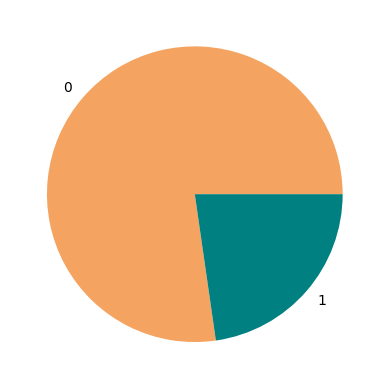

0    185181
1     54447
Name: label_killed, dtype: int64


In [18]:
show_distribution(incidents_clsf['label_killed'])

In [19]:
label = incidents_clsf.pop('label_killed')

In [20]:
incidents_clsf

year  month  avg_age_participants  n_injured  n_arrested  n_unharmed  \
0       2013     12                    22          5           2           0   
1       2013      7                    22          4           1           0   
2       2014      6                    36          1           0           1   
3       2014      7                    26          2           0           0   
4       2014      5                    27          0           0           1   
...      ...    ...                   ...        ...         ...         ...   
239623  2019      1                    40          1           0           0   
239624  2019      8                    40          0           0           1   
239625  2019      1                    40          0           0           0   
239626  2020      1                    40          1           0           1   
239627  2020     10                    40          0           0           1   

        n_participants  povertyPercentage  state_num  city_or_county_num  \
0                   10               17.5          0                7627   
1                    5               17.5          0                3905   
2                    2               16.8          0                 435   
3                    5               16.8          0                3644   
4                    2               16.8          0                5382   
...                ...                ...        ...                 ...   
239623               1                9.4         50                9871   
239624               2                9.4         50                2017   
239625               1                9.4         50                8814   
239626               2                8.7         50                2017   
239627               1                8.7         50                9395   

        party_num  
0               2  
1               2  
2               2  
3               1  
4               2  
...           ...  
239623          0  
239624          0  
239625          0  
239626          0  
239627          0  

[239628 rows x 11 columns]

## Prepare the cleaned dataset for classification
Split the dataset into training e validation set. In this section we will split the dataset in order to obtain a training set and a validation set for the training phase of all the models.
The percentage that we choose is 80% of the data for the training set and 20% for the validation set.

In [21]:
X_dev, X_test, y_dev, y_test = train_test_split(incidents_clsf, label, random_state=42, test_size=0.20, stratify=label,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=42, test_size=0.20, stratify=y_dev,shuffle=True)

In [22]:
# Normalization
scaler = StandardScaler()
X_std_dev = scaler.fit_transform(X_dev)
X_std_train = scaler.fit_transform(X_train)
X_std_val = scaler.fit_transform(X_val)
X_std_test = scaler.fit_transform(X_test)

## Classification

In [23]:
# Functions that prints the classification report
def report_scores(test_label, test_pred):
    print(classification_report(test_label,
                            test_pred,
                            target_names=['killed', 'no-killed']))

## Classification with a Decision Tree

In [ ]:
#define a decision tree and fit it
from sklearn import tree

def build_decision_tree(X, y, cv=6, print_res=True):
    params = [{
    'criterion': ['gini'],
    'max_depth': [None],
    'max_features': [None],
    'min_samples_split': [4],
    'min_samples_leaf': [4]
    }]
    clf = GridSearchCV(tree.DecisionTreeClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("DT - Best parameters set found:")
        print(clf.best_params_)
        print("DT - Best accuraccy score found:")
        print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

In [ ]:
best_score_dt, best_dt = build_decision_tree(X_std_dev, y_dev)

Fitting 6 folds for each of 1 candidates, totalling 6 fits
DT - Best parameters set found:
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 4}
DT - Best accuraccy score found:
0.9623373771982976


In [ ]:
y_pred_test = best_dt.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

      killed       0.97      0.98      0.98     37037
   no-killed       0.93      0.90      0.91     10889

    accuracy                           0.96     47926
   macro avg       0.95      0.94      0.94     47926
weighted avg       0.96      0.96      0.96     47926



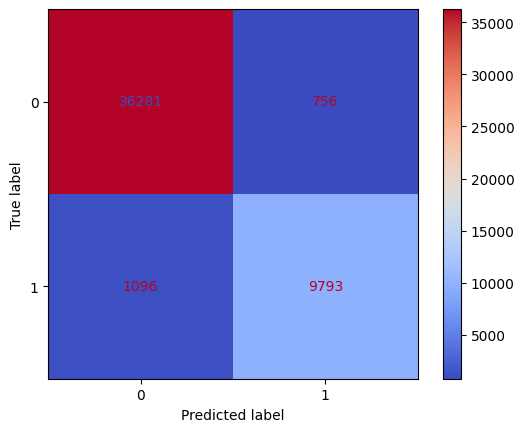

In [ ]:
#it is possible to plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(best_dt, X_std_test, y_test, cmap='coolwarm')
plt.show()

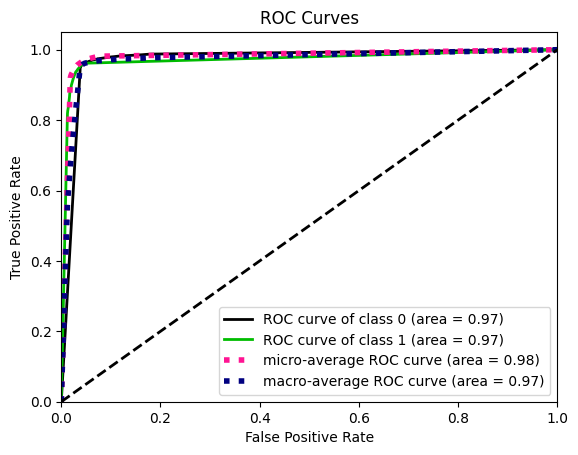

In [ ]:
plot_roc(y_test, best_dt.predict_proba(X_std_test))
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.125629 to fit



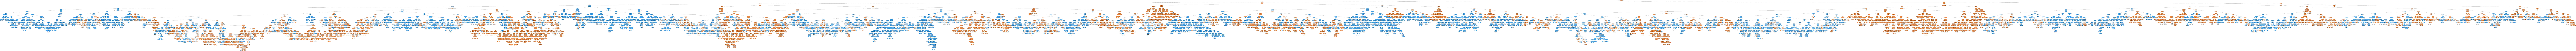

In [ ]:
#visualize the actual decision tree obtained
import pydotplus
from IPython.display import Image
dot_data = tree.export_graphviz(best_dt, out_file=None,
                         feature_names=list(X_train.columns),
                         class_names=['<=50', '>50'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Classification with KNN

In [ ]:
k_list = [x for x in range(1, 20)]
knn_list = []
acc_tr_list = []
acc_val_list = []


for k in tqdm(k_list):
    # Create knn model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_std_train, y_train)
    knn_list.append(knn)
    # Predict for train and validation sets
    y_pred_train = knn.predict(X_std_train)
    y_pred_val = knn.predict(X_std_val)
    # Accuracy
    acc_tr = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    acc_tr_list.append(acc_tr)
    acc_val_list.append(acc_val)

100%|██████████| 19/19 [29:19<00:00, 92.61s/it] 


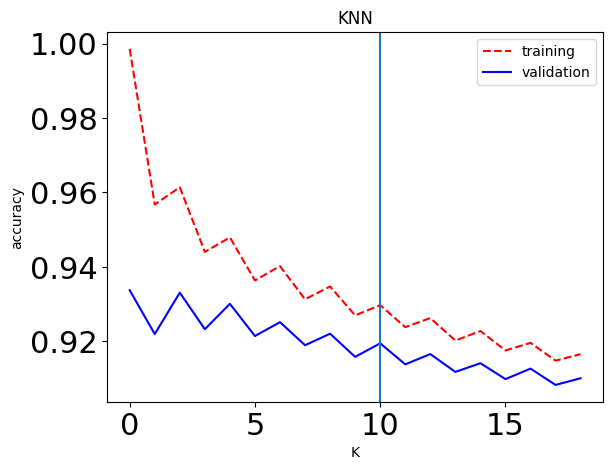

In [ ]:
plt.plot(range(len(acc_tr_list)), acc_tr_list, 'r--', label='training')
plt.plot(range(len(acc_val_list)), acc_val_list, 'b-',  label='validation')
plt.ylabel('accuracy')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('KNN')
plt.axvline(10)
plt.legend(loc="upper right")
plt.show()

Select the best n as the graph shows

In [ ]:
knn = knn_list[9]

y_pred_val = knn.predict(X_std_val)
print('## Validation:')
report_scores(y_val, y_pred_val)

y_pred_test = knn.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Validation:
              precision    recall  f1-score   support

      killed       0.92      0.98      0.95     29629
   no-killed       0.91      0.70      0.79      8712

    accuracy                           0.92     38341
   macro avg       0.91      0.84      0.87     38341
weighted avg       0.92      0.92      0.91     38341

## Test:
              precision    recall  f1-score   support

      killed       0.92      0.98      0.95     37037
   no-killed       0.92      0.70      0.79     10889

    accuracy                           0.92     47926
   macro avg       0.92      0.84      0.87     47926
weighted avg       0.92      0.92      0.91     47926



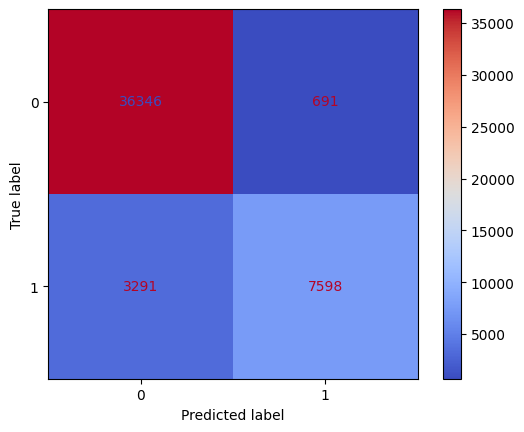

In [ ]:
#it is possible to plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(knn, X_std_test, y_test, cmap='coolwarm')
plt.show()

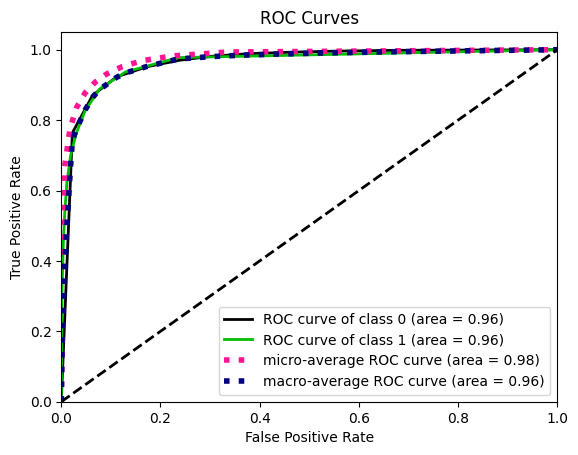

In [ ]:
plot_roc(y_test, knn.predict_proba(X_std_test))
plt.show()

## Classification with Random Forest

In [ ]:
# Function that finds the best random forest doing hyperparameter search through CV.
# Retrains on the whole set at the end.
def build_random_forest(X, y, cv=6, print_res=True):
    params = [{
    'max_depth': [5, 15, None],
    'max_features': ['log2', None],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [32, 64, 128]
    }]
    clf = GridSearchCV(RandomForestClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("RF - Best parameters set found:")
        print(clf.best_params_)
        print("RF - Best accuraccy score found:")
        print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

In [ ]:
best_score_rf, best_rf = build_random_forest(X_std_dev, y_dev)

Fitting 6 folds for each of 54 candidates, totalling 324 fits
RF - Best parameters set found:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'n_estimators': 64}
RF - Best accuraccy score found:
0.9709809974575211


In [ ]:
y_pred_test = best_rf.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

      killed       0.98      0.98      0.98     37037
   no-killed       0.93      0.94      0.94     10889

    accuracy                           0.97     47926
   macro avg       0.96      0.96      0.96     47926
weighted avg       0.97      0.97      0.97     47926



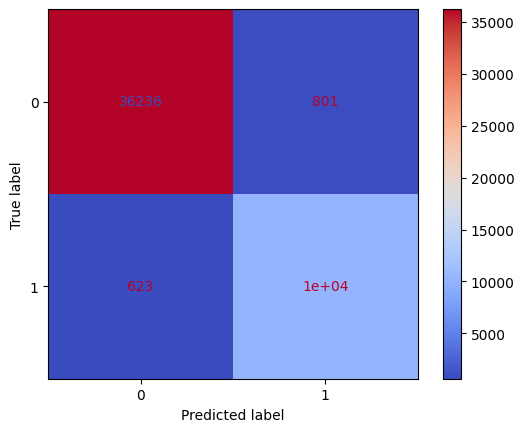

In [ ]:
#it is possible to plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rf, X_std_test, y_test, cmap='coolwarm')
plt.show()

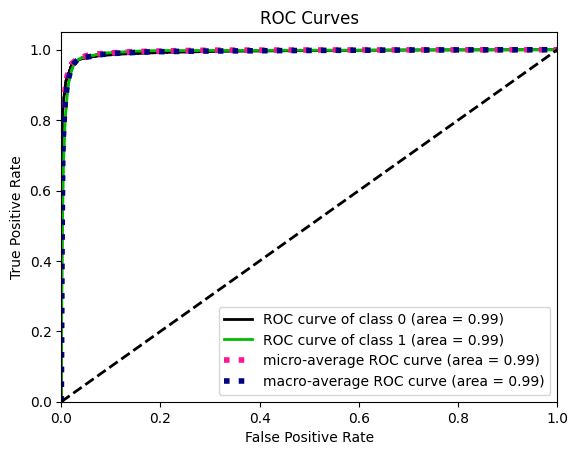

In [ ]:
plot_roc(y_test, best_rf.predict_proba(X_std_test))
plt.show()

## Classification with SVM

In [25]:
# Function that finds the best random forest doing hyperparameter search through CV.
# Retrains on the whole set at the end.
def build_SVM(X, y, cv=6, print_res=True):
    params = [
    {"kernel": ["linear", "sigmoid"], "gamma": ["scale"], "C": [2]}]
    clf = GridSearchCV(svm.SVC(probability=True), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("SVM - Best parameters set found:")
        print(clf.best_params_)
        print("SVM - Best accuracy score found:")
        print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

In [ ]:
best_score_svm, best_svm = build_SVM(X_std_dev, y_dev)

In [ ]:
y_pred_test = best_svm.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

In [ ]:
#it is possible to plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(best_svm, X_std_test, y_test, cmap='coolwarm')
plt.show()

In [ ]:
plot_roc(y_test, best_svm.predict_proba(X_std_test,probability=True))
plt.show()

## Classification with AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(X_std_dev, y_dev)

AdaBoostClassifier()

In [ ]:
y_pred_test = ada.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

      killed       0.88      0.95      0.92     37037
   no-killed       0.77      0.57      0.66     10889

    accuracy                           0.86     47926
   macro avg       0.83      0.76      0.79     47926
weighted avg       0.86      0.86      0.86     47926



In [ ]:
base = tree.DecisionTreeClassifier(max_depth = 6)
ada_tree = AdaBoostClassifier(base_estimator = base, n_estimators=200, learning_rate=0.1)
ada_tree.fit(X_std_dev, y_dev)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=0.1, n_estimators=200)

In [ ]:
y_pred_test = ada_tree.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

      killed       0.97      0.98      0.98     37037
   no-killed       0.92      0.91      0.92     10889

    accuracy                           0.96     47926
   macro avg       0.95      0.95      0.95     47926
weighted avg       0.96      0.96      0.96     47926



In [ ]:
def build_AdaBoost(X, y, cv=6, print_res=True):
  #define the parameters' values you want to try
  trees_params = [tree.DecisionTreeClassifier(max_depth = 6), tree.DecisionTreeClassifier(max_depth = 7)]
  param_dist = {"base_estimator" : trees_params,
                "n_estimators": list(np.arange(150, 350, 50)),
                "learning_rate": np.arange(0.05, 0.1, 0.02)}
  #define the number of iters
  n_iter_search = 40
  #define the model
  ada_tree = AdaBoostClassifier()
  #define the grid search
  clf = GridSearchCV(ada_tree, param_dist,
                              #n_iter=n_iter_search,
                              n_jobs=-1,
                              verbose=10,
                              scoring=make_scorer(accuracy_score),
                              cv = 4)
  #run the grid search
  clf.fit(X, y)
  if print_res:
      print("SVM - Best parameters set found:")
      print(clf.best_params_)
      print("SVM - Best accuracy score found:")
      print(clf.best_score_)

  return(clf.best_score_, clf.best_estimator_)

In [ ]:
best_score_ada, best_ada = build_AdaBoost(X_std_dev, y_dev)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


SVM - Best parameters set found:
{'base_estimator': DecisionTreeClassifier(max_depth=7), 'learning_rate': 0.05, 'n_estimators': 300}
SVM - Best accuracy score found:
0.9634276126355552


In [ ]:
y_pred_test = best_ada.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

      killed       0.97      0.98      0.98     37037
   no-killed       0.93      0.91      0.92     10889

    accuracy                           0.96     47926
   macro avg       0.95      0.94      0.95     47926
weighted avg       0.96      0.96      0.96     47926



## Classification with Rule Based

In [ ]:
#we run a grid search to find the best configuration of parameters' values
import wittgenstein as lw
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.4], "k": [1]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(X_std_dev, y_dev)

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

In [ ]:
best_param = grid_search.best_params_
ripper = lw.RIPPER(k=best_param['k'], prune_size=best_param['prune_size'])
X_std_dev_df = pd.DataFrame(X_std_dev)
y_dev_series = pd.Series(y_dev)
datas = pd.concat([X_std_dev_df, y_dev_series], axis=1)
ripper.fit(datas, class_feat='label_killed', pos_class=1)

In [ ]:
ripper.out_model()

In [ ]:
y_pred_test = ripper.predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
#it is possible to plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(ripper, X_std_test, y_test, cmap= 'coolwarm')
plt.show()

In [ ]:
plot_roc(y_test, ripper.predict_proba(X_std_test))
plt.show()

## Classification with Bayesian Classifier

In [ ]:
gnb = GaussianNB()

y_pred_val = gnb.fit(X_std_train, y_train).predict(X_std_val)
print('## Training:')
report_scores(y_val, y_pred_val)

## Training:
              precision    recall  f1-score   support

      killed       0.79      0.97      0.87     29629
   no-killed       0.58      0.15      0.24      8712

    accuracy                           0.78     38341
   macro avg       0.69      0.56      0.55     38341
weighted avg       0.75      0.78      0.73     38341



In [ ]:
bnb = BernoulliNB()

y_pred_val = bnb.fit(X_std_train, y_train).predict(X_std_val)
print('## Validation:')
report_scores(y_val, y_pred_val)

## Validation:
              precision    recall  f1-score   support

      killed       0.79      0.99      0.88     29629
   no-killed       0.86      0.11      0.19      8712

    accuracy                           0.79     38341
   macro avg       0.83      0.55      0.54     38341
weighted avg       0.81      0.79      0.73     38341



In [ ]:
bnb = BernoulliNB()

y_pred_test = bnb.fit(X_std_dev, y_dev).predict(X_std_test)
print('## Test:')
report_scores(y_test, y_pred_test)

## Test:
              precision    recall  f1-score   support

      killed       0.79      0.99      0.88     37037
   no-killed       0.86      0.12      0.21     10889

    accuracy                           0.80     47926
   macro avg       0.83      0.56      0.54     47926
weighted avg       0.81      0.80      0.73     47926



## Classification with Neural Network

In [ ]:
# Function that builds a NN from a list configuration containing layer neurons
def build_nn(layers_config):
    model = Sequential()

    for i, layer_neurons in enumerate(layers_config):
        # Add hidden layers with the current number of neurons
        if i==0: # First layer
            model.add(Dense(layer_neurons, activation='relu', input_dim=X_std_train.shape[1]))
        else:
            model.add(Dropout(.2))
            model.add(Dense(layer_neurons, activation='relu', input_dim=layers_config[i-1]))

    # Add the output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
# Define a list of possible lists of numbers of neurons for each layer
layers_config_list = [[48, 16], [24, 12], [64, 24, 6]]

history_list = []
models_list = []
val_acc_list = []

# Iterate over all possible combinations of number of layers and neurons
for layers_config in layers_config_list:
    # Builds NN architecture
    model = build_nn(layers_config)

    # Add early stopping that checks val loss
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                    mode ="min", patience = 3,
                                    restore_best_weights = True)

    # Train the model on the training set
    history = model.fit(X_std_train, y_train, validation_data = (X_std_val,y_val),
        epochs=40, batch_size=32, verbose=0, callbacks=[earlystopping])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_std_val, y_val, verbose=0)

    # Save and show results
    print('NN with ', layers_config, 'configuration - Validation Score:', accuracy,
        '- Epochs:', earlystopping.stopped_epoch)
    history_list.append(history)
    models_list.append(model)
    val_acc_list.append(accuracy)

NN with  [48, 16] configuration - Validation Score: 0.9587386846542358 - Epochs: 23
NN with  [24, 12] configuration - Validation Score: 0.9531311392784119 - Epochs: 13
NN with  [64, 24, 6] configuration - Validation Score: 0.9548003673553467 - Epochs: 6


In [ ]:
best_nn_index = 0

best_history = history_list[best_nn_index]
best_nn = models_list[best_nn_index]

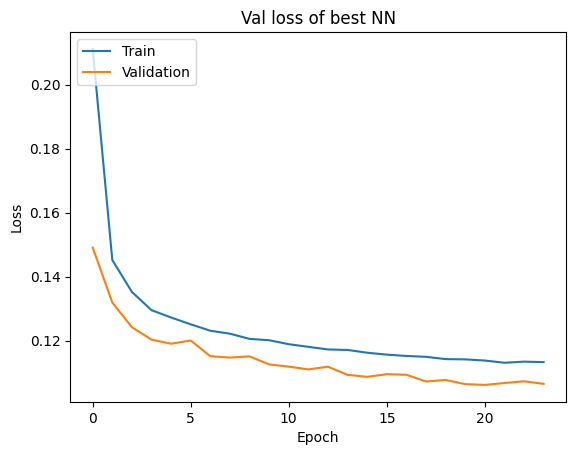

In [ ]:
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Val loss of best NN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Builds NN architecture
model = build_nn(layers_config_list[best_nn_index])

# Train the model on the whole development set
final_history = model.fit(X_std_train, y_train, validation_data = (X_std_val, y_val), epochs=24, batch_size=32, verbose=0)

# Evaluate the model on the test set
y_pred_test = np.rint(model.predict(X_std_test, verbose=0))

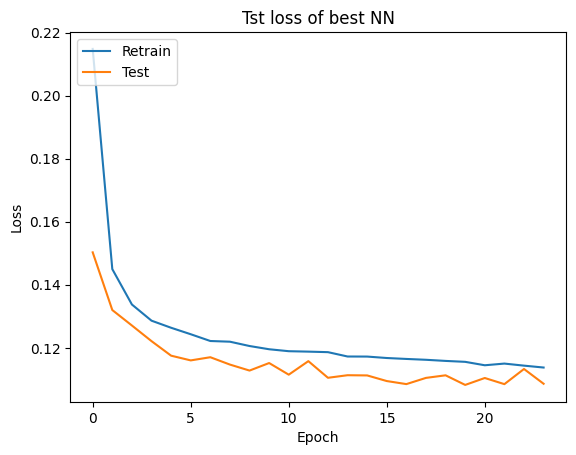

In [ ]:
plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
plt.title('Tst loss of best NN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Retrain', 'Test'], loc='upper left')
plt.show()

In [ ]:
print('NN with ', layers_config, 'configuration')
report_scores(y_test, y_pred_test)

NN with  [64, 24, 6] configuration
              precision    recall  f1-score   support

      killed       0.98      0.97      0.97     37037
   no-killed       0.90      0.93      0.91     10889

    accuracy                           0.96     47926
   macro avg       0.94      0.95      0.94     47926
weighted avg       0.96      0.96      0.96     47926

